# Classification des cellules sanguines cancéreuses (PyTorch).

## 1️⃣ Importation et préparation des données

### Imports : 

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import random
import os
import cv2
from typing import Counter

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix

import torchviz
from torchview import draw_graph



### Charger les images du dataset et vérifier leurs extensions (jpeg, jpg, bmp, png). Supprimer celles qui ne correspondent pas.

In [270]:
dataset_path = Path("../data/Blood_Cells_Cancer/")

valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

images = []
labels = []

In [271]:
problem_files = 0

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            if file_name.lower().endswith(valid_extensions):
                
                try:
                    img = cv2.imread(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(class_name)
                    else:
                        problem_files += 1
                        print(f"Impossible de lire l'image : {file_path}")
                        # supprimer si le file ne s'ouvre pas
                        try:
                            os.remove(file_path)
                        except Exception as e:
                            print(f"Erreur lors de la suppression de {file_path} : {e}")
                        
                except Exception as e :
                    print(f"Erreur lors du chargement de {file_path} : {e}")
                    
            else:
                problem_files += 1
                print(f"Extension non valide, fichier {file_path}")
                # supprimer si le fichier n'a pas l'extension valide
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Erreur lors de la suppression de {file_path} : {e}")
                
        

In [272]:
print(f"Nombre total d'images valides : {len(images)}")
print(f"Nombre de fichiers problématiques : {problem_files}")

Nombre total d'images valides : 3242
Nombre de fichiers problématiques : 0


## 2️⃣ Exploration et visualisation du dataset

### Explorer les classes du dataset (les noms des dossiers représentent les classes).

In [273]:
# Explorer les classes
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print(f"Les classes sont : {classes}")

Les classes sont : ['Benign', 'early Pre-B', 'Pre-B', 'Pro-B']


### Montrez un nombre d’échantillons dans chaque classe par countplot.

C:\Users\ramas\AppData\Local\Temp\ipykernel_3812\443092441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, order=pd.Series(labels).value_counts().index, palette='viridis')


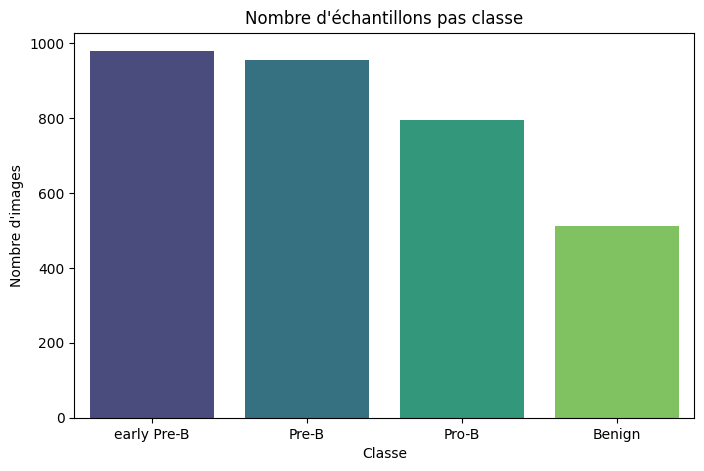

In [274]:
# affichier les nombres des classes avec un plot
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, order=pd.Series(labels).value_counts().index, palette='viridis')
plt.title("Nombre d'échantillons pas classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

In [275]:
# Nombre des images par classe : 

class_counts = Counter(np.array(labels))
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}' : {count} images")

Classe 'Benign' : 512 images
Classe 'early Pre-B' : 979 images
Classe 'Pre-B' : 955 images
Classe 'Pro-B' : 796 images


### Montrer un échantillon d’images pour chaque classe.

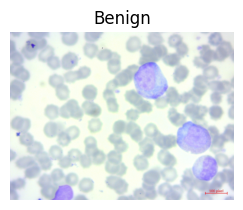

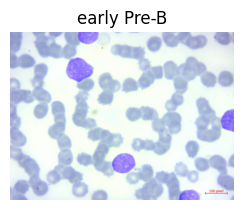

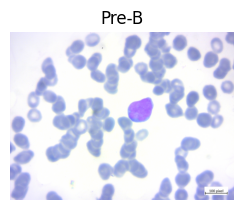

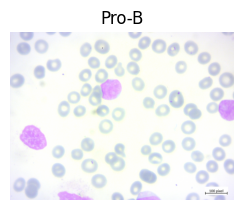

In [276]:
# Benign exp. image

img1_path = '../data/Blood_Cells_Cancer/Benign/Snap_027.jpg'

image = cv2.imread(img1_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Benign")
plt.axis('off')
plt.show()

# early Pre-B exp. image

img2_path = '../data/Blood_Cells_Cancer/early Pre-B/Sap_148 (51).jpg'

image = cv2.imread(img2_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("early Pre-B")
plt.axis('off')
plt.show()


# Pre-B exp. image

img3_path = '../data/Blood_Cells_Cancer/Pre-B/Snap_009.jpg'

image = cv2.imread(img3_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Pre-B")
plt.axis('off')
plt.show()

# early Pro-B exp. image

img4_path = '../data/Blood_Cells_Cancer/Pro-B/Snap_013.jpg'

image = cv2.imread(img4_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_min, y_min, x_max, y_max = 300, 300, 450, 450

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Pro-B")
plt.axis('off')
plt.show()

## 3️⃣ Division du dataset

### Diviser les images en trois ensembles (dossiers) : Train, Validation et Test, selon la répartition suivante : 70 % pour l’entraînement, 15 % pour la validation et 15 % pour le test.

In [277]:
# mixer dataset 
data_compined = list(zip(images, labels))
random.seed(42)
random.shuffle(data_compined)
images, labels = zip(*data_compined)
images = list(images)
labels = list(labels)

In [278]:
import splitfolders
splitfolders.ratio(dataset_path, output="../data/data_split", seed=42, ratio=(.7, .15, .15))


### Compter les images dans chaque dossier.

In [279]:
base_dir = "../data/data_split"
sets = ['train', 'val', 'test']

data_counts = []

for set_name in sets:
    set_path = os.path.join(base_dir, set_name)
    total_images = 0
    print(f"\n ✅ {set_name}")
    
    for class_name in os.listdir(set_path):
        class_path = os.path.join(set_path, class_name)
        
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            total_images += count
            data_counts.append([set_name, class_name, count])
            print(f"------> Total images dans {class_name} : {count}")
    print(f"=> Total images dans {set_name} : {total_images}")


 ✅ train
------> Total images dans Benign : 358
------> Total images dans early Pre-B : 685
------> Total images dans Pre-B : 668
------> Total images dans Pro-B : 557
=> Total images dans train : 2268

 ✅ val
------> Total images dans Benign : 76
------> Total images dans early Pre-B : 146
------> Total images dans Pre-B : 143
------> Total images dans Pro-B : 119
=> Total images dans val : 484

 ✅ test
------> Total images dans Benign : 78
------> Total images dans early Pre-B : 148
------> Total images dans Pre-B : 144
------> Total images dans Pro-B : 120
=> Total images dans test : 490


In [280]:
df_counts = pd.DataFrame(data_counts, columns=["Dataset", "Classe", "Nombre d'images"])
# df_counts

C:\Users\ramas\AppData\Local\Temp\ipykernel_3812\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


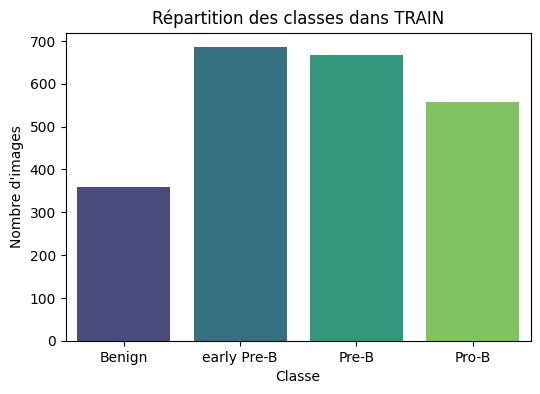

C:\Users\ramas\AppData\Local\Temp\ipykernel_3812\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


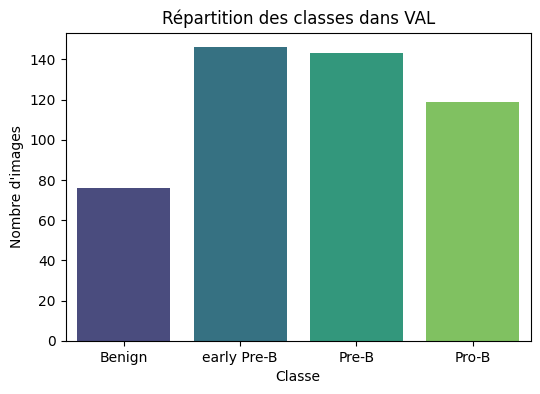

C:\Users\ramas\AppData\Local\Temp\ipykernel_3812\2188269180.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")


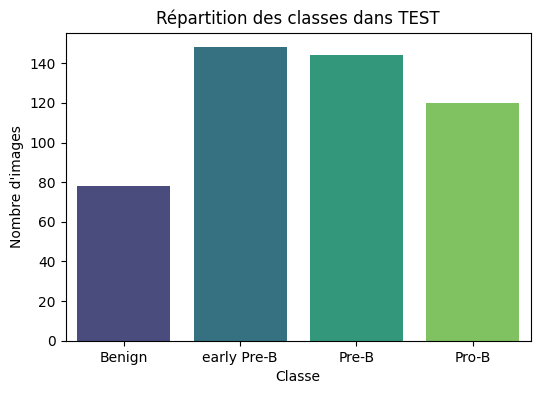

In [281]:
# afficher avec des graphes le nombres des images de cahque classe dans train, test,val

for set_name in sets:
    plt.figure(figsize=(6, 4))
    subset = df_counts[df_counts["Dataset"] == set_name]
    sns.barplot(x="Classe", y="Nombre d'images", data=subset, palette="viridis")
    plt.title(f"Répartition des classes dans {set_name.upper()}")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.show()

## 4️⃣ Augmentation des données

* Appliquer des transformations telles que "blur, noise et flip" sur les données d’entraînement afin d’équilibrer les classes et augmenter le nombre d’images.


In [282]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
])

* Utiliser les Transforms de PyTorch dans le Dataset(ImageFolder) pour redimensionner les images, les convertir en tenseurs et les normaliser


In [283]:
train_data = datasets.ImageFolder('../data/data_split/train', transform=train_transforms)
val_data = datasets.ImageFolder('../data/data_split/val', transform=val_transforms)
test_data = datasets.ImageFolder('../data/data_split/test', transform=val_transforms)


## 5️⃣ Chargement des données

In [284]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

* Voir des exemples des images transformées


 Train  : 


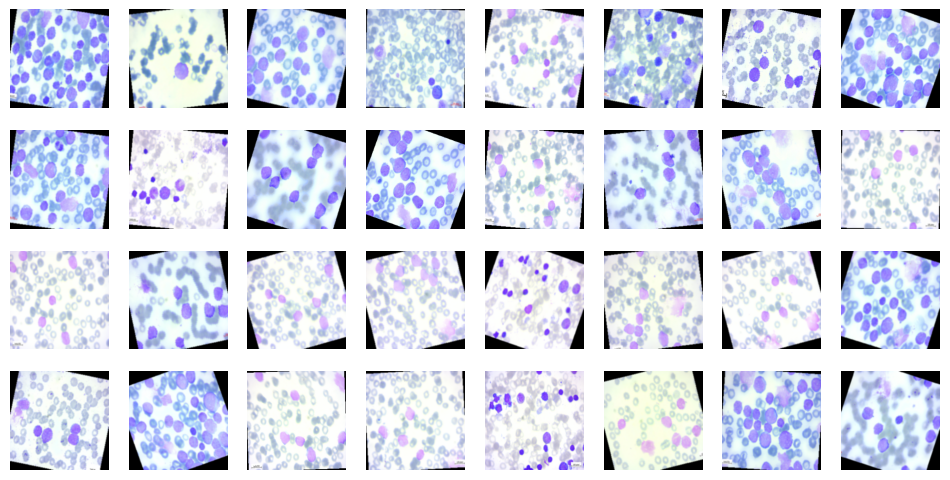


 Test  : 


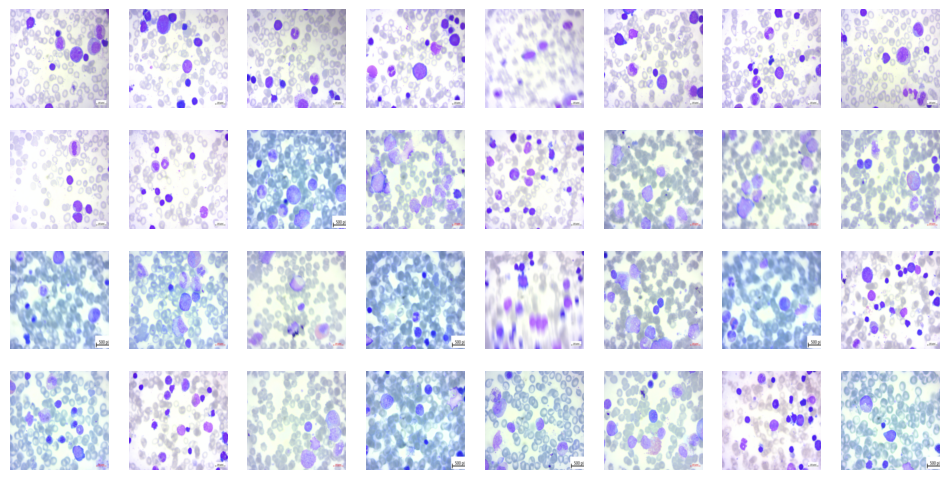


 Val  : 


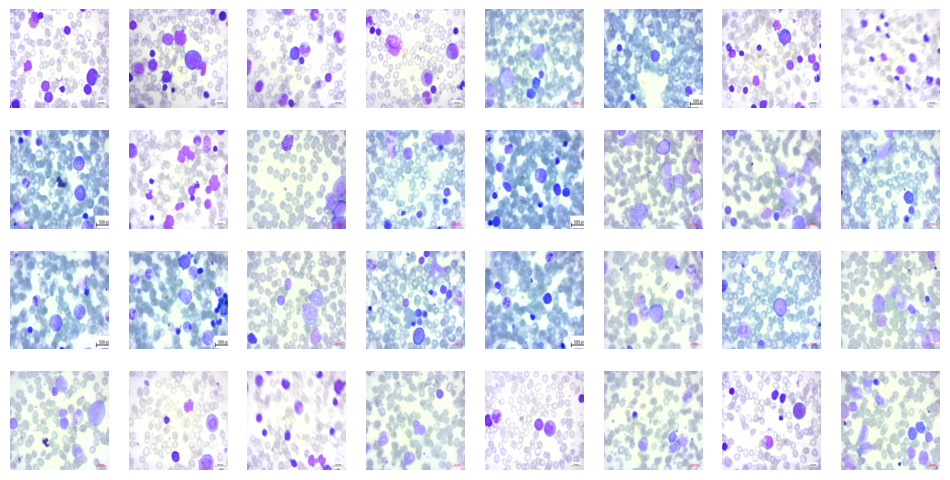

In [285]:
def img_show_batch(dataloder, title):
    images, labels = next(iter(dataloder))
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) +  [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
    print("\n",title, " : ")
    plt.show()
    
img_show_batch(train_loader, title="Train")
img_show_batch(test_loader, title="Test")
img_show_batch(val_loader, title="Val")

## 6️⃣ Construction du modèle

### Utiliser le modèle pré-entraîné GoogLeNet et remplacer sa partie fully connected (FC) par un réseau séquentiel entièrement connecté, adapté à la tâche spécifique de classification.

* Charger le modèle pré-entrainé GoogleNet : 

In [286]:
model = models.googlenet(pretrained=True)

c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [287]:
# Avec Modifier le FC

x = torch.randn(1, 3, 224, 224)
y = model(x)
torchviz.make_dot(y, params=dict(model.named_parameters())).render("../googlenet_avant", format="png")

'..\\googlenet_avant.png'

In [288]:
model.fc

Linear(in_features=1024, out_features=1000, bias=True)

* Remplacer la partie fully connected (FC) par un réseau séquentiel adapté à la tâche

In [289]:
nbr_classes = len(classes)

model.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(), 
    nn.Dropout(0.3),
    nn.Linear(in_features=512 , out_features=nbr_classes)
)

In [290]:
model.fc

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)

In [291]:
# Après la modification de FC

x = torch.randn(1, 3, 224, 224)
y = model(x)
torchviz.make_dot(y, params=dict(model.named_parameters())).render("../googlenet_apres", format="png")

'..\\googlenet_apres.png'

## 7️⃣ Entraînement et évaluation du modèle : 

* Déterminer le learning rate, la fonction de perte et l’optimiseur

In [292]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [293]:
learning_rate = 0.0001
loss_funct = nn.CrossEntropyLoss()
optimiseur = optim.Adam(model.fc.parameters(), lr=learning_rate)

* Entraîner le modèle

In [294]:
nbr_epochs = 20

train_loss = []
train_accuracy = []
val_accuracy = []

print(f"▶️ Start Entraînement ⌛ ...")

for epoch in range(nbr_epochs):
    
    print(f"\nStart Epoch [{epoch+1}/{nbr_epochs}] : ")
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimiseur.zero_grad()
        outputs = model(images)
        loss = loss_funct(outputs, labels)
        loss.backward()
        optimiseur.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_acc = correct / total
    val_acc = 0
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
        val_acc = correct_val / total_val
        loss_train = running_loss/len(train_loader)
        
        val_accuracy.append(val_acc)
        train_accuracy.append(train_acc)
        train_loss.append(loss_train)
        
    print(f"    Epoch [{epoch+1}/{nbr_epochs}] - Loss: {loss_train:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
print(f"✅ Entrînement terminé !")

▶️ Start Entraînement ⌛ ...

Start Epoch [1/20] : 
    Epoch [1/20] - Loss: 1.0404 | Train Acc: 0.6795 | Val Acc: 0.8120

Start Epoch [2/20] : 
    Epoch [2/20] - Loss: 0.5695 | Train Acc: 0.8774 | Val Acc: 0.9029

Start Epoch [3/20] : 
    Epoch [3/20] - Loss: 0.3828 | Train Acc: 0.9184 | Val Acc: 0.8988

Start Epoch [4/20] : 
    Epoch [4/20] - Loss: 0.2863 | Train Acc: 0.9272 | Val Acc: 0.9339

Start Epoch [5/20] : 
    Epoch [5/20] - Loss: 0.2477 | Train Acc: 0.9339 | Val Acc: 0.9442

Start Epoch [6/20] : 
    Epoch [6/20] - Loss: 0.2255 | Train Acc: 0.9414 | Val Acc: 0.9421

Start Epoch [7/20] : 
    Epoch [7/20] - Loss: 0.1906 | Train Acc: 0.9502 | Val Acc: 0.9442

Start Epoch [8/20] : 
    Epoch [8/20] - Loss: 0.1852 | Train Acc: 0.9458 | Val Acc: 0.9380

Start Epoch [9/20] : 
    Epoch [9/20] - Loss: 0.1545 | Train Acc: 0.9581 | Val Acc: 0.9545

Start Epoch [10/20] : 
    Epoch [10/20] - Loss: 0.1629 | Train Acc: 0.9502 | Val Acc: 0.9545

Start Epoch [11/20] : 
    Epoch [11/20

* Évaluer et tester le modèle après l’entraînement afin de mesurer ses performances, sa précision, et sa capacité à généraliser sur des données inédites.

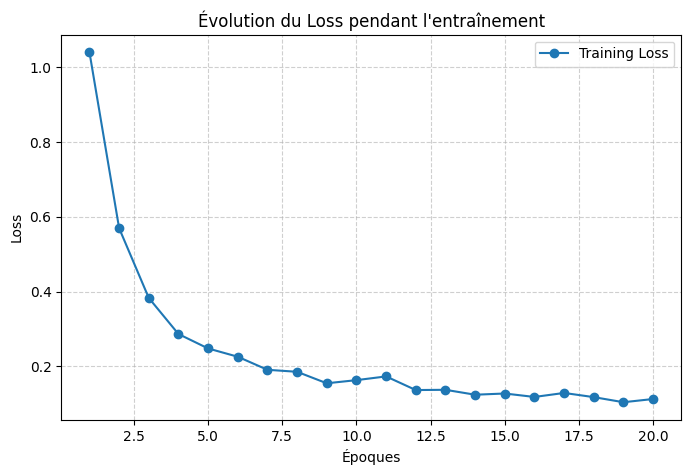

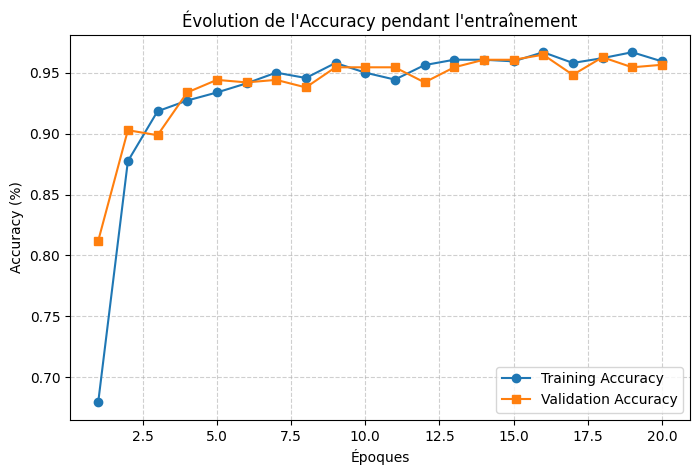

In [307]:
import matplotlib.pyplot as plt

# Époques
epochs = list(range(1, nbr_epochs+1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.title("Évolution du Loss pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, marker='s', label='Validation Accuracy')
plt.title("Évolution de l'Accuracy pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


* rapport de classification : 

In [ ]:
model.eval()

# test
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_funct(outputs, labels)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)

        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
        
avg_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f"Test Loss Moyenne : {avg_loss:.4f} ")
print(f"Test Accuracy : {accuracy:.2f}")
        
        
        

Test Loss Moyenne : 0.0976 
Test Accuracy : 0.96


In [315]:
print("\n Rapport de classification : ")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))


 Rapport de classification : 
              precision    recall  f1-score   support

      Benign       0.97      0.85      0.90        78
       Pre-B       0.95      0.99      0.97       144
       Pro-B       0.98      1.00      0.99       120
 early Pre-B       0.95      0.97      0.96       148

    accuracy                           0.96       490
   macro avg       0.97      0.95      0.96       490
weighted avg       0.96      0.96      0.96       490



* matrice de confusion : 

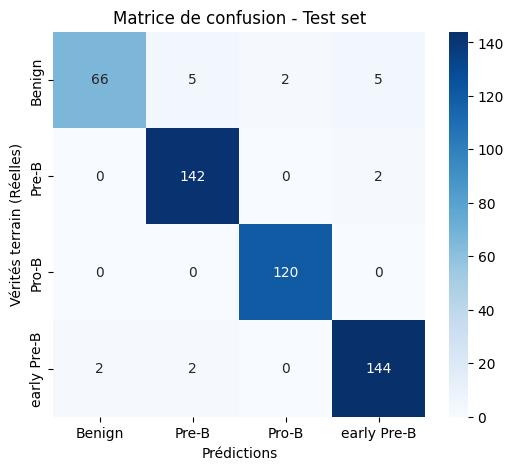

In [316]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes,
            yticklabels=test_data.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain (Réelles)")
plt.title("Matrice de confusion - Test set")
plt.show()


* Sauvegarder le modèle entraîné

In [317]:
torch.save(model.state_dict(), "../models/blood_cells_googlenet_model.pth")
print("✅ Modèle sauvegardé : blood_cells_googlenet.model.pth")

✅ Modèle sauvegardé : blood_cells_googlenet.model.pth
